In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt

import config
import load_data
import model

CONF = config.load_config()
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [15, 15]

C:\Users\pages\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_prediction(sess, graph, path_to_model):
    # Preparing data
    subprocess.call(
      [CONF.ROTAMERS_EXE_PATH, "--mode", "map", "-i", path_to_model, "-m", "24", "-v", "0.8", "-o",
       CONF.TEMP_PATH +'_ana.bin'])
    if not os.path.exists(CONF.TEMP_PATH +'_ana.bin'):
        return [], [], []
    
    predDataset = load_data.read_data_set(CONF.TEMP_PATH +'_ana.bin')
    
    os.remove(CONF.TEMP_PATH +'_ana.bin')

    # creating placeholder for input data and feed dict
    maps_placeholder = graph.get_tensor_by_name('main_input:0')
    is_training = graph.get_tensor_by_name('is_training:0')

    # Placeholder for output
    logits = graph.get_tensor_by_name("main_output:0")
    router = graph.get_tensor_by_name("out_router_1:0")
    
    
    preds = []
    all_branches = []
    for i in range(predDataset.num_res):
      f_map = np.reshape(predDataset.maps[i], (1, model.GRID_VOXELS * model.NB_TYPE))
      training = False

      feed_dict = {maps_placeholder: f_map, is_training: training}
      pred, branches = sess.run([logits, router],
                      feed_dict=feed_dict)
        
      preds.append(pred)
      all_branches.append(branches)
        
    return preds, all_branches, predDataset.meta

In [3]:
def get_sec_struct(path_prot, sec_to_int):
    
    temp_file = '/home/benoitch/Temp/out_sec_structure'
    with open(temp_file,'w') as f_out:
        subprocess.call(['stride',path_prot],stdout=f_out)
    with open(temp_file,'r') as f:
        lines = f.readlines()
        
    sec_struct = []
    num = []
    for l in lines:
        parse = l.split(' ')
        if not parse[0] == 'ASG':
            continue
        res = []
        
        for s in parse:
            if not s == '':
                res.append(s)
        sec_struct.append(sec_to_int[res[6]])
        num.append(int(res[3]))
    if len(num) == 0:
        print(lines)
        
    return sec_struct, num
       

In [4]:
model_dir = '/home/benoitch/save/tests_cluster/Model_def_2/'

with open('/home/benoitch/save/tests/feeding_order_35k','r') as f:
    lines = f.readlines()
path = []

for l in lines:
    path.append(l[:-1])
    
np.random.shuffle(path)    
paths = path[:30]




used_path = []
# importing saved model

sess = tf.Session()

print('Restore existing model: %s' % (model_dir))
print('Latest checkpoint: %s' % (tf.train.latest_checkpoint(model_dir)))

saver = tf.train.import_meta_graph(tf.train.latest_checkpoint(model_dir) + '.meta')
saver.restore(sess, tf.train.latest_checkpoint(model_dir))

graph = tf.get_default_graph()

FileNotFoundError: [Errno 2] No such file or directory: '/home/benoitch/save/tests/feeding_order_35k'

In [23]:
_preds = []
_branches = []
_meta = []

file_missing = 0
mapping_corrupted = 0

# getting infos about residues and predictions
for prot_path in paths:
    print('> Predicting path :', prot_path)
    p_, b_, m_= get_prediction(sess, graph, prot_path)
    
    if len(p_) == 0:
        print('# skip file')
        file_missing += 1
        continue
    count_b = 0
    for b in b_:
        if np.argmax(b) == 5:
            count_b +=1
            
    if count_b/len(b_) >= 0.5:
        mapping_corrupted += 1
        print('# Branche 5 massively represented : skipping protein')
        continue
    
    
    used_path.append(prot_path)
    _preds.append(p_)
    _branches.append(b_)
    _meta.append(m_)
    
paths = used_path
print('>> informations exctracted')
print('>', mapping_corrupted + file_missing, 'errors detected.')
print('>', mapping_corrupted, 'corrupted maps.')
print('>', file_missing, 'missing file.')

> Predicting path : /home/benoitch/data/CASP7/MODELS/T0312/T0312TS443_3
Extracting /home/benoitch/Temp/Maps/map_ana.bin
> Predicting path : /home/benoitch/data/CASP7/MODELS/T0373/T0373TS087_4
Extracting /home/benoitch/Temp/Maps/map_ana.bin
> Predicting path : /home/benoitch/data/CASP8/MODELS/T0426/T0426TS116_1
Extracting /home/benoitch/Temp/Maps/map_ana.bin
> Predicting path : /home/benoitch/data/CASP11/MODELS/T0805/T0805TS184_2
Extracting /home/benoitch/Temp/Maps/map_ana.bin
> Predicting path : /home/benoitch/data/CASP10/MODELS/T0648/T0648TS198_2
Extracting /home/benoitch/Temp/Maps/map_ana.bin
> Predicting path : /home/benoitch/data/CASP10/MODELS/T0664/T0664TS419_4
Extracting /home/benoitch/Temp/Maps/map_ana.bin
> Predicting path : /home/benoitch/data/CASP10/MODELS/T0712/T0712TS456_5
Extracting /home/benoitch/Temp/Maps/map_ana.bin
> Predicting path : /home/benoitch/data/CASP9/MODELS/T0531/T0531TS029_2
Extracting /home/benoitch/Temp/Maps/map_ana.bin
> Predicting path : /home/benoitch/d

In [32]:
# reformating data

meta_ = _meta
meta = []

for p in meta_:
    for r in p:
        meta.append(r.tolist())

preds_ = _preds
preds = []

for p in preds_:
    for r in p:
        preds.append(r.tolist())


branches_ = _branches
branches = []

for p in branches_:
    for r in p:
        branches.append(r.tolist())  

In [33]:
branches = np.squeeze(np.array(branches))
print(branches.shape)
preds = np.array(preds)
print(preds.shape)
meta = np.array(meta)
print(meta.shape)

(6697, 22)
(6697,)
(6697, 16)


In [34]:
# extracting informations about residues
res_num = meta[:,0]
res_type_int = meta[:,1]
res_score = meta[:,2]/1000000

res_type_chr = [chr(i) for i in res_type_int]

nb_type = len(set(res_type_chr))

chr_to_int = dict([(sorted(list(set(res_type_chr)))[i],i) for i in range(nb_type)])

print(chr_to_int)
print('>>', len(meta), 'residues found.')

{'R': 14, 'Y': 19, 'D': 2, 'L': 9, 'I': 7, 'F': 4, 'H': 6, 'V': 17, 'W': 18, 'G': 5, 'Q': 13, 'N': 11, 'P': 12, 'K': 8, 'E': 3, 'M': 10, 'A': 0, 'T': 16, 'S': 15, 'C': 1}
>> 6697 residues found.


In [35]:
# exctracting secondary structure
structure = sorted(['Coil','Turn','Strand','310Helix','AlphaHelix','Bridge','PiHelix'])
sec_to_int = dict(zip(structure,range(len(structure))))

sec_struct_indix = []
ss =[]
ss_all_indix = []

for l in range(len(paths)):
    s, n = get_sec_struct(paths[l],sec_to_int)
    num_mapped = meta_[l][:,0]
    
    prot_indix = list(set(n).intersection(num_mapped))
    
    sec_struct_indix.append(prot_indix)
    ss_all_indix.append(n)
    ss.append(s)

# Routing according to the type of residue

[]

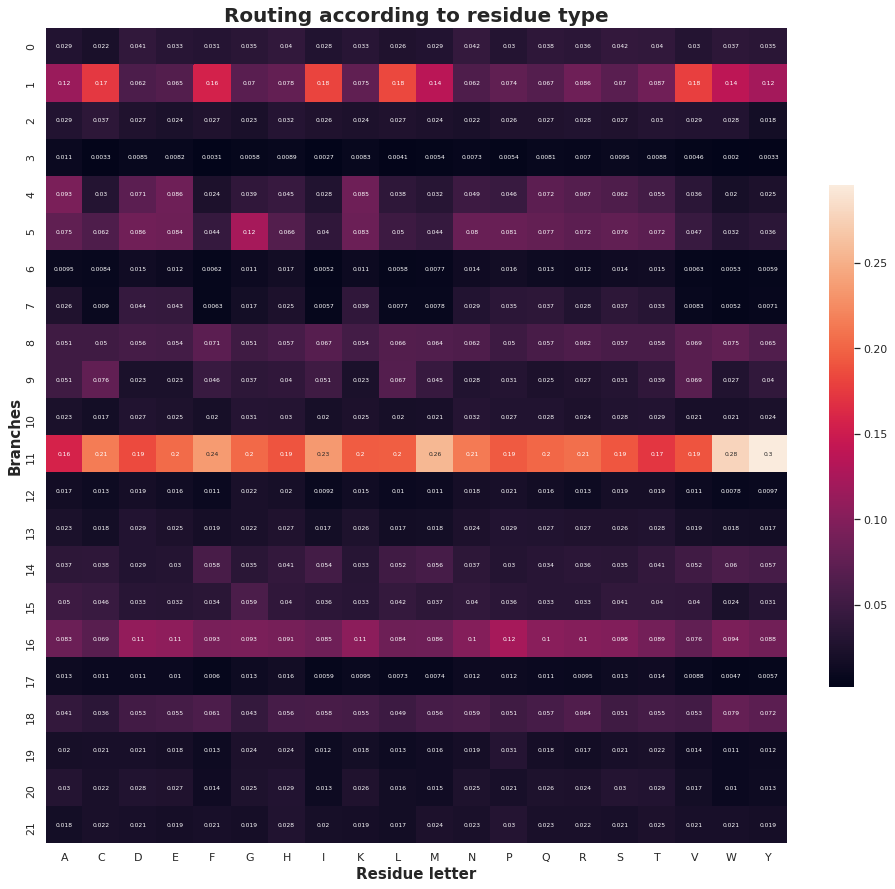

In [28]:
# What branche for what res
nb_res = len(meta)

matrix = np.zeros((nb_type, len(np.squeeze(branches[0]))), dtype=np.float64)
count_type = np.zeros(nb_type, dtype=np.int64)


for i in range(nb_res):
    matrix[chr_to_int[res_type_chr[i]],:] += np.squeeze(branches[i])
    count_type[chr_to_int[res_type_chr[i]]] += 1

for i in range(nb_type):
    matrix[i] = matrix[i]/count_type[i]
    
ax = sns.heatmap(matrix.T,square=True,annot=True,annot_kws={"size":6},cbar_kws={"fraction":0.03},xticklabels=list(sorted(chr_to_int.keys())))
ax.set_ylabel('Branches',size=15, fontdict={'weight': 'bold'})
ax.set_xlabel('Residue letter',size=15, fontdict={'weight': 'bold'})
ax.set_title('Routing according to residue type',size=20, fontdict={'weight': 'bold'})
plt.plot()

[]

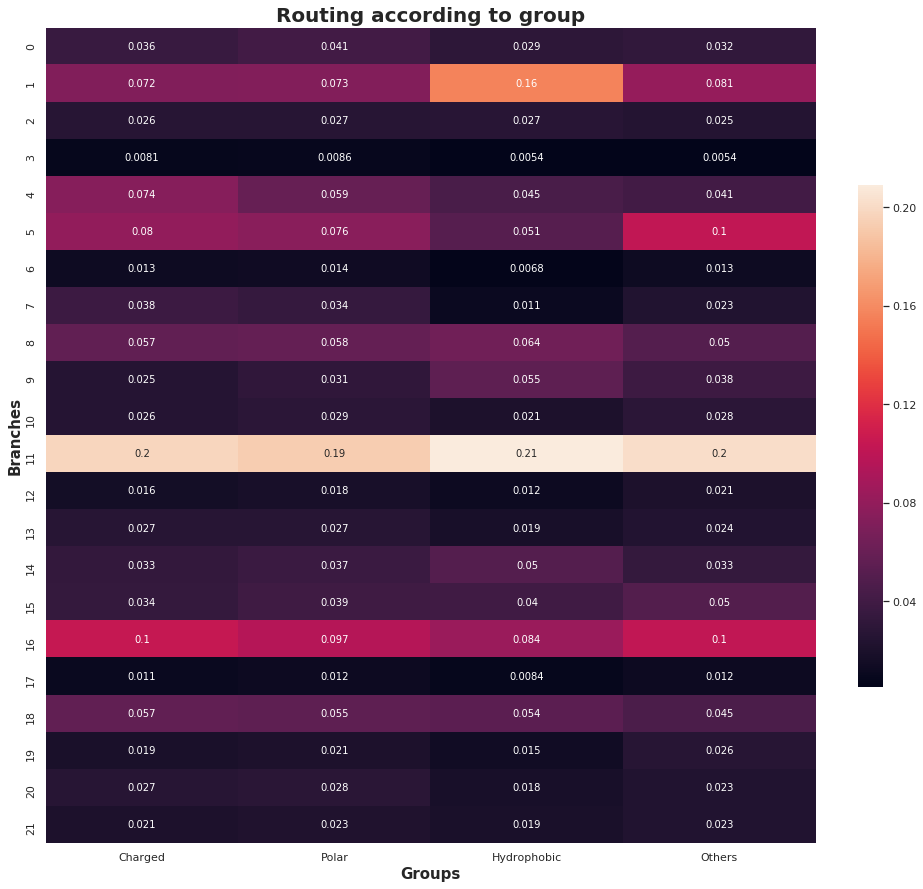

In [31]:
# What branche for what res
res_to_grp = {'A':2,'C':3,'D':0,'E':0,'F':2,'G':3,'H':0,'I':2,'K':0,'L':2,'M':2,'N':1,'P':3,'Q':1,'R':0,'S':1,'T':1,'V':2,'W':2,'Y':2}
grps = ['Charged','Polar','Hydrophobic','Others']
matrix_grp = np.zeros((4, len(np.squeeze(branches[0]))), dtype=np.float64)
count_type = np.zeros(4, dtype=np.int64)


for i in range(nb_res):
    matrix_grp[res_to_grp[res_type_chr[i]],:] += np.squeeze(branches[i])
    count_type[res_to_grp[res_type_chr[i]]] += 1

for i in range(4):
    matrix_grp[i] = matrix_grp[i]/count_type[i]
    
ax = sns.heatmap(matrix_grp.T, square=False, annot=True, annot_kws={"size":10}, cbar_kws={"fraction":0.03}, xticklabels=grps)
ax.set_ylabel('Branches',size=15, fontdict={'weight': 'bold'})
ax.set_xlabel('Groups',size=15, fontdict={'weight': 'bold'})
ax.set_title('Routing according to group',size=20, fontdict={'weight': 'bold'})
plt.plot()

# Routing according to the residue quality

[]

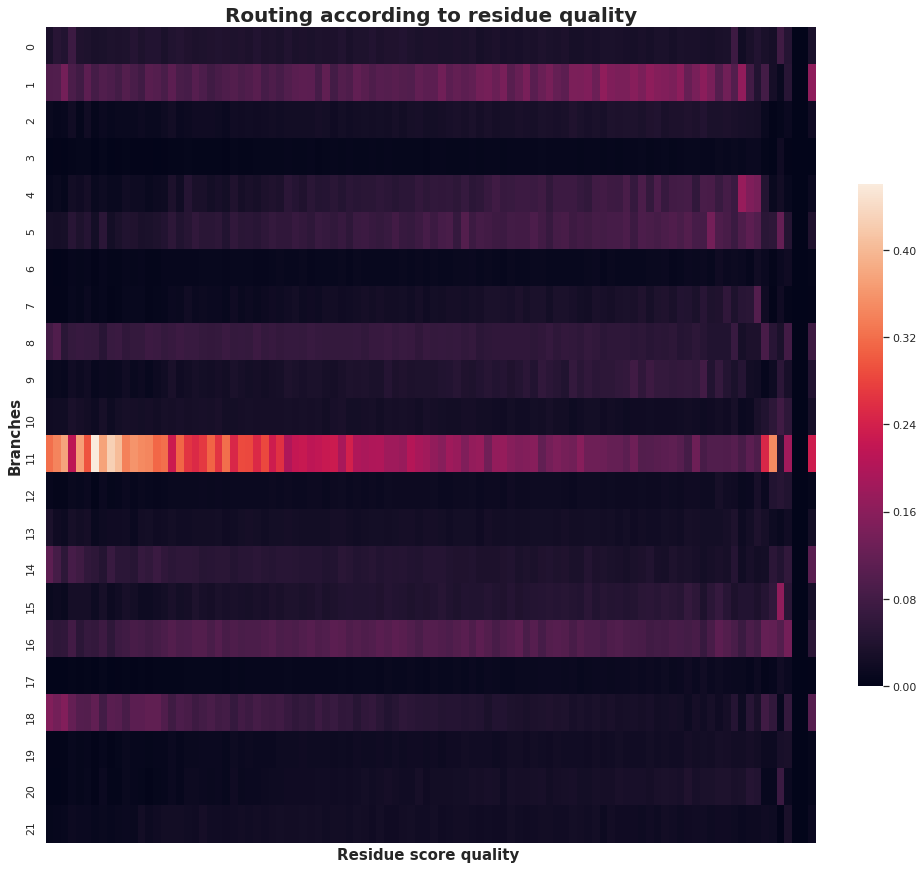

In [98]:
nb_seg = 100
matrix_2 = np.zeros((nb_seg, len(np.squeeze(branches[0]))), dtype=np.float64)

ls_seg = np.linspace(0,1,nb_seg + 1)

count_weight = np.ones(nb_seg, dtype=np.int64)
first = [True for i in range(nb_seg)]

for i in range(nb_res):
    sco = res_score[i]
    id_ = len(ls_seg[np.where(ls_seg < sco)]) - 1
    matrix_2[id_,:] += np.squeeze(branches[i])
    if first[id_]:
        first[id_] = False
    else:
        count_weight[id_] += 1
    
for i in range(nb_seg):
    matrix_2[i] = matrix_2[i]/count_weight[i]
    
ax = sns.heatmap(matrix_2.T,square=False,annot=False,annot_kws={"size":7},cbar_kws={"fraction":0.03},xticklabels=False)
ax.set_ylabel('Branches',size=15, fontdict={'weight': 'bold'})
ax.set_xlabel('Residue score quality ',size=15, fontdict={'weight': 'bold'})
ax.set_title('Routing according to residue quality',size=20, fontdict={'weight': 'bold'})
plt.plot()
    

# Routing according to secondary structure

[]

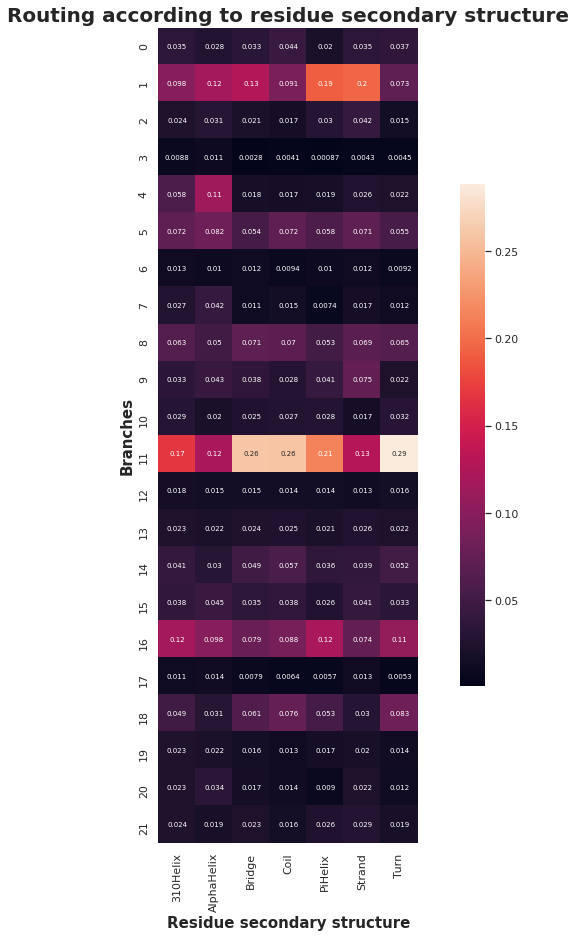

In [110]:
nb_seg = len(sec_to_int)
matrix_3 = np.zeros((nb_seg, len(np.squeeze(branches[0]))), dtype=np.float64)

count_weight = np.zeros(nb_seg, dtype=np.int64)

for p in range(len(_meta)):
    
    i_ = 0
    for i in range(len(_meta[p])):
        if _meta[p][i][0] == sec_struct_indix[p][i_]:
            
        
            id_ss = ss_all_indix[p].index(sec_struct_indix[p][i_])
            id_ = ss[p][id_ss]
    
            matrix_3[id_,:] += np.squeeze(_branches[p][i])
    
            count_weight[id_] += 1
            i_ += 1
            
for i in range(nb_seg):
    matrix_3[i] = matrix_3[i]/count_weight[i]
    
ax = sns.heatmap(matrix_3.T,square=True,annot=True,annot_kws={"size":7},cbar_kws={"fraction":0.03},xticklabels=sorted(list(sec_to_int)))
ax.set_ylabel('Branches',size=15, fontdict={'weight': 'bold'})
ax.set_xlabel('Residue secondary structure',size=15, fontdict={'weight': 'bold'})
ax.set_title('Routing according to residue secondary structure',size=20, fontdict={'weight': 'bold'})
plt.plot()

In [68]:
for s in ss: print(set(s))

{0, 1, 3, 5, 6}
{1, 2, 3, 5, 6}
{0, 1, 3, 5, 6}
{0, 1, 3, 5, 6}
{0, 1, 2, 3, 5, 6}
{2, 3, 5, 6}
{0, 2, 3, 5, 6}
{1, 3, 6}
{1, 2, 3, 5, 6}
{0, 1, 2, 3, 5, 6}
{0, 1, 2, 3, 5, 6}
{2, 3, 5, 6}
{0, 1, 2, 3, 5, 6}
{0, 3, 6}
{1, 2, 3, 6}
{0, 1, 2, 3, 5, 6}
{0, 2, 3, 5, 6}
{0, 1, 2, 3, 5, 6}


In [69]:
sec_to_int

{'310Helix': 0,
 'AlphaHelix': 1,
 'Bridge': 2,
 'Coil': 3,
 'PiHelix': 4,
 'Strand': 5,
 'Turn': 6}